# Recursive learning of patterns via RNN

After we have learned to predict the next note via a neural network, it still lacks the capability to

* understand and predict 
* has no sense of time
* is not aware of velocity/amplitude of a note



In [1]:
import lightning as L
import numpy as np
import torch
from ki_ueben.datasets import Maestro3Dataset
from ki_ueben.midi import PianoRoll
from torch import nn, optim

Start by loading the dataset.

Extract the events within a MIDI file through the `PianoRoll` class.

In [2]:
import lightning as L
from torch import nn, optim


class BasicRecursionNet(L.LightningModule):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        num_layers: int = 1
    ):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.criterion = nn.BCEWithLogitsLoss()
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        # only use output from last step of our rnn sequence
        output = self.fc(rnn_out[:, -1, :])
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.squeeze(1))
        self.log("train_loss", loss, prog_bar=True)
        return loss

    # def test_step(self, batch, batch_idx):
    #     x, y = batch
    #     z = self.net(x)
    #     test_loss = self.criterion(z, y)
    #     self.log("test_loss", test_loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-4)


basic_recursion_net = BasicRecursionNet(
    input_size=89,
    output_size=89,
    hidden_size=40,
    num_layers=2,
)

print(basic_recursion_net)

BasicRecursionNet(
  (rnn): RNN(89, 40, num_layers=2, batch_first=True)
  (fc): Linear(in_features=40, out_features=89, bias=True)
  (criterion): BCEWithLogitsLoss()
)


In [15]:
from ki_ueben.datasets import Maestro3Dataset, PianoRollDataset
from torch.utils.data import DataLoader

WINDOW_SIZE = 50

piano_roll_dataset = PianoRollDataset(
    # limit the number of MIDI files
    midi_files=Maestro3Dataset().midi_file_paths[0:16*8],
    window_size=WINDOW_SIZE,
)

In [5]:
for sample in piano_roll_dataset:
    piano_roll_sample = sample
    break
piano_roll_sample

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [6]:
context_data_loader = DataLoader(piano_roll_dataset, batch_size=256, num_workers=32)

/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
from pytorch_lightning.loggers import CSVLogger
import torch 

# for tensor cores
torch.set_float32_matmul_precision('high')

simple_trainer = L.Trainer(
    max_epochs=5, logger=[CSVLogger(save_dir="logs", name="basic_recursion_net", version=0)]
)
simple_trainer.fit(model=basic_recursion_net, train_dataloaders=context_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/basic_recursion_net/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/basic_recursion_net/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | rnn       | RNN               | 8.5 K  | train
1 | fc        | Linear            | 3.6 K  | train
2 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
12.2 K   

Epoch 4: |          | 14514/? [03:13<00:00, 74.97it/s, v_num=0, train_loss=0.00218]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 14514/? [03:13<00:00, 74.97it/s, v_num=0, train_loss=0.00218]


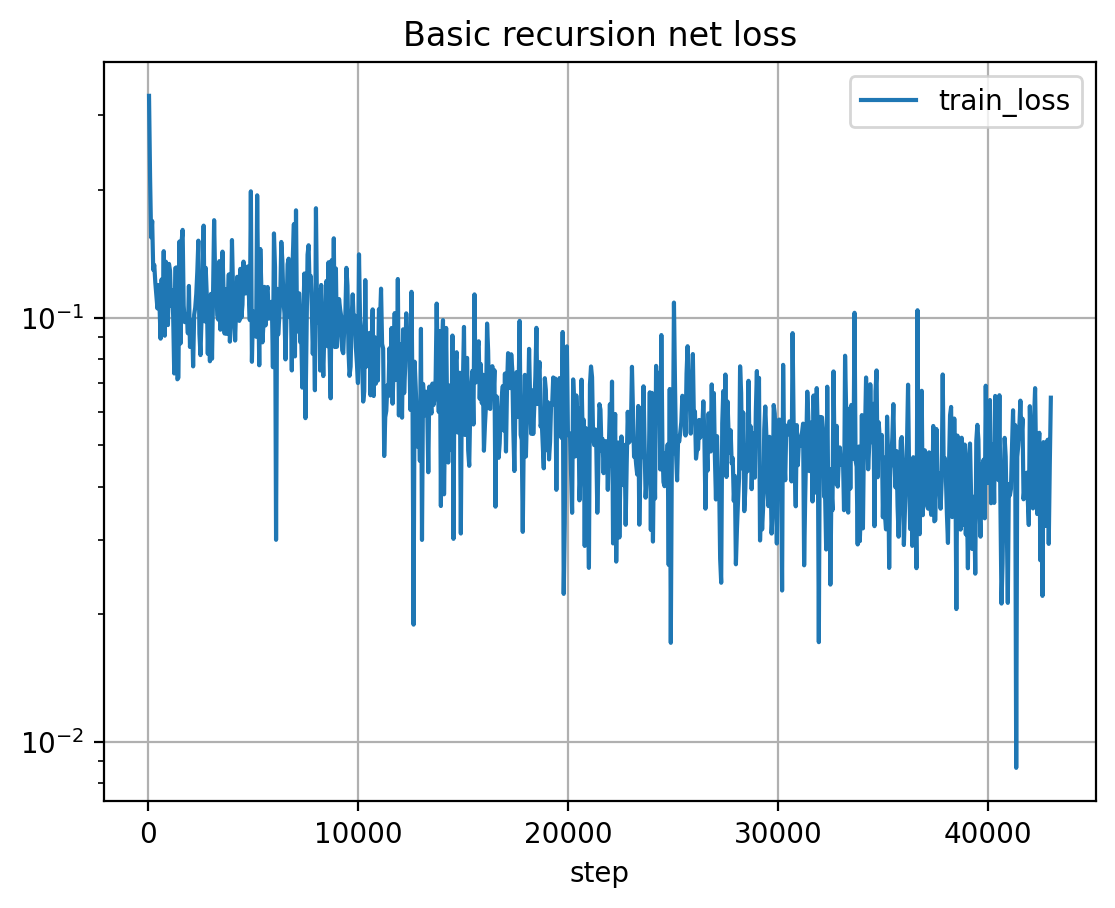

In [29]:
import pandas as pd

df_simple_metrics = pd.read_csv("logs/basic_recursion_net/version_0/metrics.csv")
df_simple_metrics.plot.line(
    grid=True, title="Basic recursion net loss", x="step", y="train_loss", logy=True
);

In [9]:
for sample in piano_roll_dataset:
    piano_roll_sample = sample
    break
piano_roll_sample

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

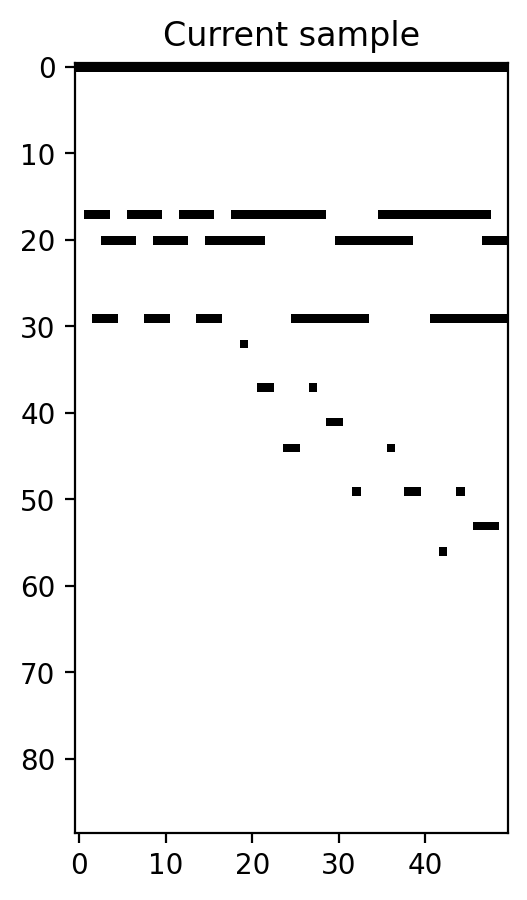

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(piano_roll_sample[0].T, cmap="binary");
plt.title("Current sample");

/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


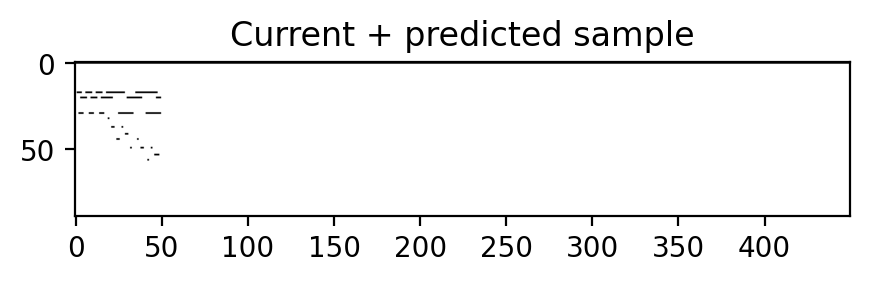

In [13]:
note_sequence = piano_roll_sample[0]

for i in range(400):
    next_frame = basic_recursion_net.forward(note_sequence.unsqueeze(0))
    binary_frame = (torch.nn.Softmax()(next_frame) > 0.01).to(torch.float32)
    note_sequence = torch.concat([note_sequence, binary_frame])

predicted_sequence = note_sequence.detach().numpy()

plt.figure(figsize=(5, 5))
plt.imshow(predicted_sequence.T, cmap="binary");
plt.title("Current + predicted sample");

## Without pedal

In [3]:
basic_wo_pedal_recursion_net = BasicRecursionNet(
    input_size=88,
    output_size=88,
    hidden_size=40,
    num_layers=2,
)

print(basic_wo_pedal_recursion_net)

BasicRecursionNet(
  (rnn): RNN(88, 40, num_layers=2, batch_first=True)
  (fc): Linear(in_features=40, out_features=88, bias=True)
  (criterion): BCEWithLogitsLoss()
)


In [4]:
from ki_ueben.datasets import Maestro3Dataset, PianoRollDataset
from torch.utils.data import DataLoader

WINDOW_SIZE = 50

piano_roll_wo_pedal_dataset = PianoRollDataset(
    # limit the number of MIDI files
    midi_files=Maestro3Dataset().midi_file_paths[0:16*8],
    window_size=WINDOW_SIZE,
    remove_pedal=True,
)

In [5]:
context_data_loader_wo_pedal = DataLoader(piano_roll_wo_pedal_dataset, batch_size=256, num_workers=16)

In [6]:
from pytorch_lightning.loggers import CSVLogger
import torch 

# for tensor cores
torch.set_float32_matmul_precision('high')

simple_trainer = L.Trainer(
    max_epochs=5, logger=[CSVLogger(save_dir="logs", name="basic_recursion_net_wo_pedal", version=0)]
)
simple_trainer.fit(model=basic_wo_pedal_recursion_net, train_dataloaders=context_data_loader_wo_pedal)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/basic_recursion_net/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/basic_recursion_net/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | rnn       | RNN               | 8.5 K  | train
1 | fc        | Linear            | 3.6 K  | train
2 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
12.1 K   

Epoch 4: |          | 14503/? [03:40<00:00, 65.92it/s, v_num=0, train_loss=0.0695] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 14503/? [03:40<00:00, 65.92it/s, v_num=0, train_loss=0.0695]


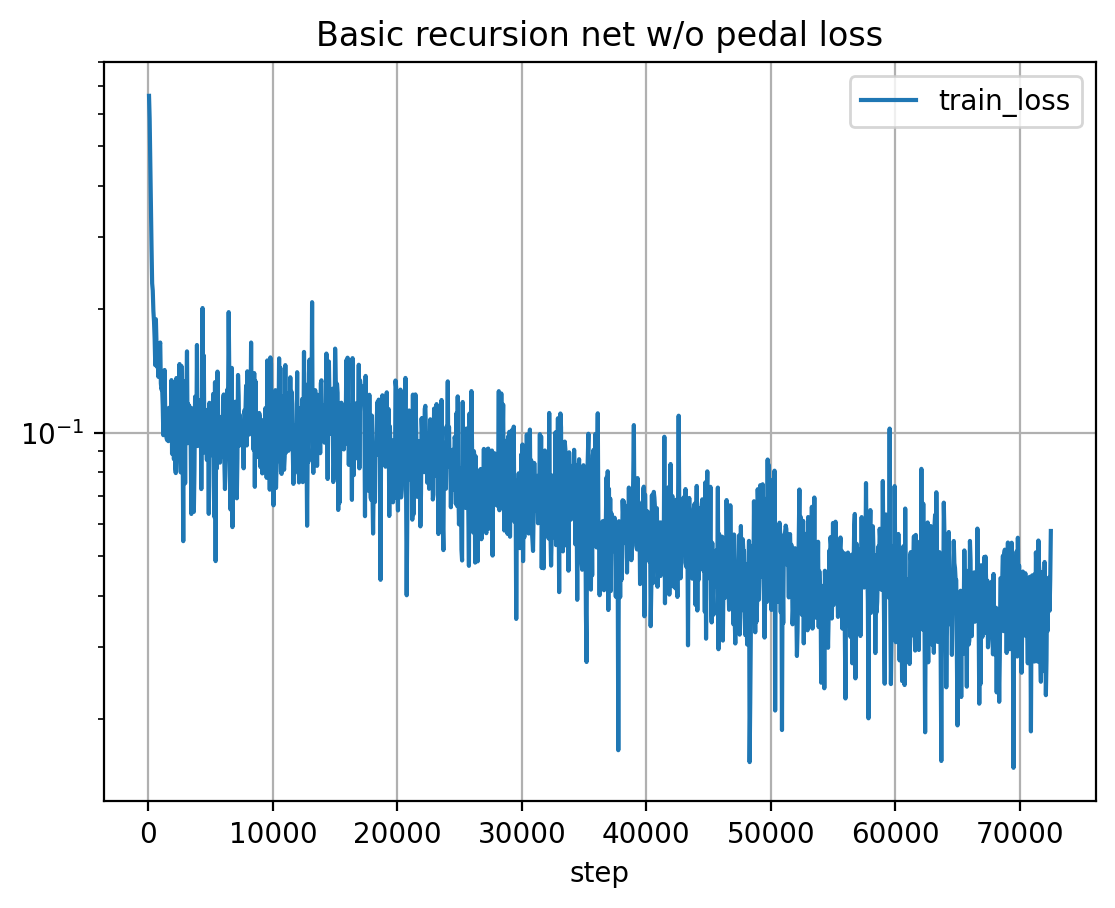

In [8]:
import pandas as pd

df_simple_metrics = pd.read_csv("logs/basic_recursion_net_wo_pedal/version_0/metrics.csv")
df_simple_metrics.plot.line(
    grid=True, title="Basic recursion net w/o pedal loss", x="step", y="train_loss", logy=True
);

In [10]:
for sample in piano_roll_wo_pedal_dataset:
    piano_roll_sample = sample
    break
piano_roll_sample

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

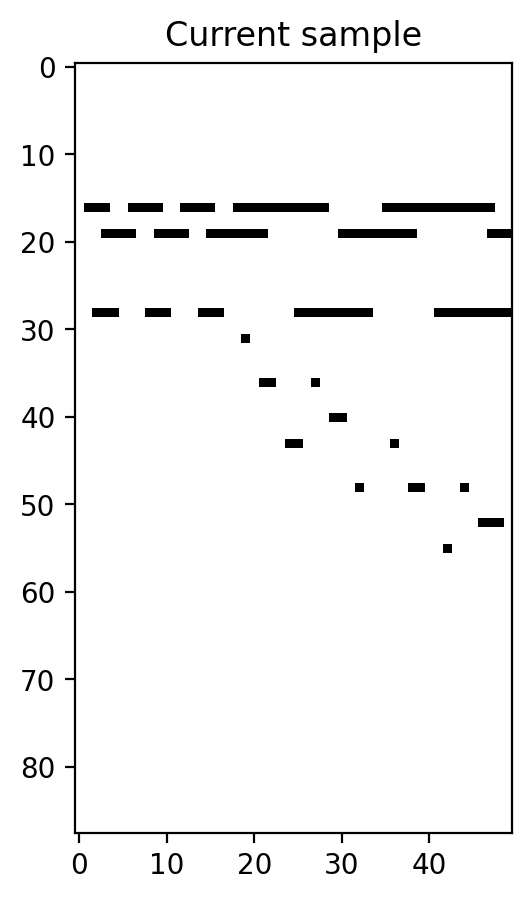

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(piano_roll_sample[0].T, cmap="binary");
plt.title("Current sample");

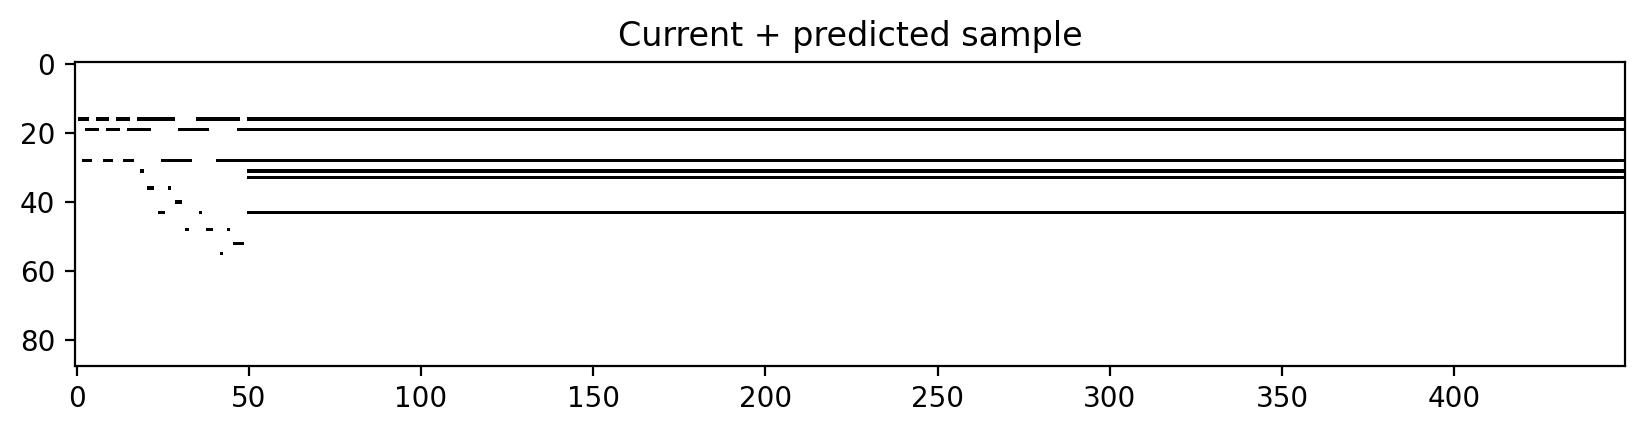

In [13]:
note_sequence = piano_roll_sample[0]

for i in range(400):
    next_frame = basic_wo_pedal_recursion_net.forward(note_sequence.unsqueeze(0))
    binary_frame = (torch.nn.Softmax()(next_frame) > 0.01).to(torch.float32)
    note_sequence = torch.concat([note_sequence, binary_frame])

predicted_sequence = note_sequence.detach().numpy()

plt.figure(figsize=(10, 5))
plt.imshow(predicted_sequence.T, cmap="binary");
plt.title("Current + predicted sample");

## LSTM

In [17]:
import lightning as L
from torch import nn, optim


class LSTMNet(L.LightningModule):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        num_layers: int = 1,
        dropout: float = 0.2,
        learning_rate: float = 1e-4,
    ):
        super().__init__()
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.criterion = nn.BCEWithLogitsLoss()
    
    def forward(self, x):
        rnn_out, _ = self.lstm(x)
        # only use output from last step of our rnn sequence
        output = self.fc(rnn_out[:, -1, :])
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.squeeze(1))
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def zero_vector_penalty(y):
        norm = torch.norm(y, p=2.0, dim=-1)
        return torch.mean(1.0 - norm)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)


lstm_net = LSTMNet(
    input_size=89,
    output_size=89,
    hidden_size=128,
    num_layers=2,
    learning_rate=1e-2,
)

print(lstm_net)

LSTMNet(
  (lstm): LSTM(89, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=89, bias=True)
  (criterion): BCEWithLogitsLoss()
)


In [16]:
context_data_loader = DataLoader(piano_roll_dataset, batch_size=256, num_workers=32)

/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
from pytorch_lightning.loggers import CSVLogger
import torch 

# for tensor cores
torch.set_float32_matmul_precision('high')

simple_trainer = L.Trainer(
    max_epochs=5, logger=[CSVLogger(save_dir="logs", name="lstm_net", version=0)]
)
simple_trainer.fit(model=lstm_net, train_dataloaders=context_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | lstm      | LSTM              | 244 K  | train
1 | fc        | Linear            | 11.5 K | train
2 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
255 K     Trainable params
0         Non-trainable params
255 K     Total params
1.023     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that 

Epoch 4: |          | 14514/? [03:45<00:00, 64.39it/s, v_num=0, train_loss=0.00162]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 14514/? [03:45<00:00, 64.39it/s, v_num=0, train_loss=0.00162]


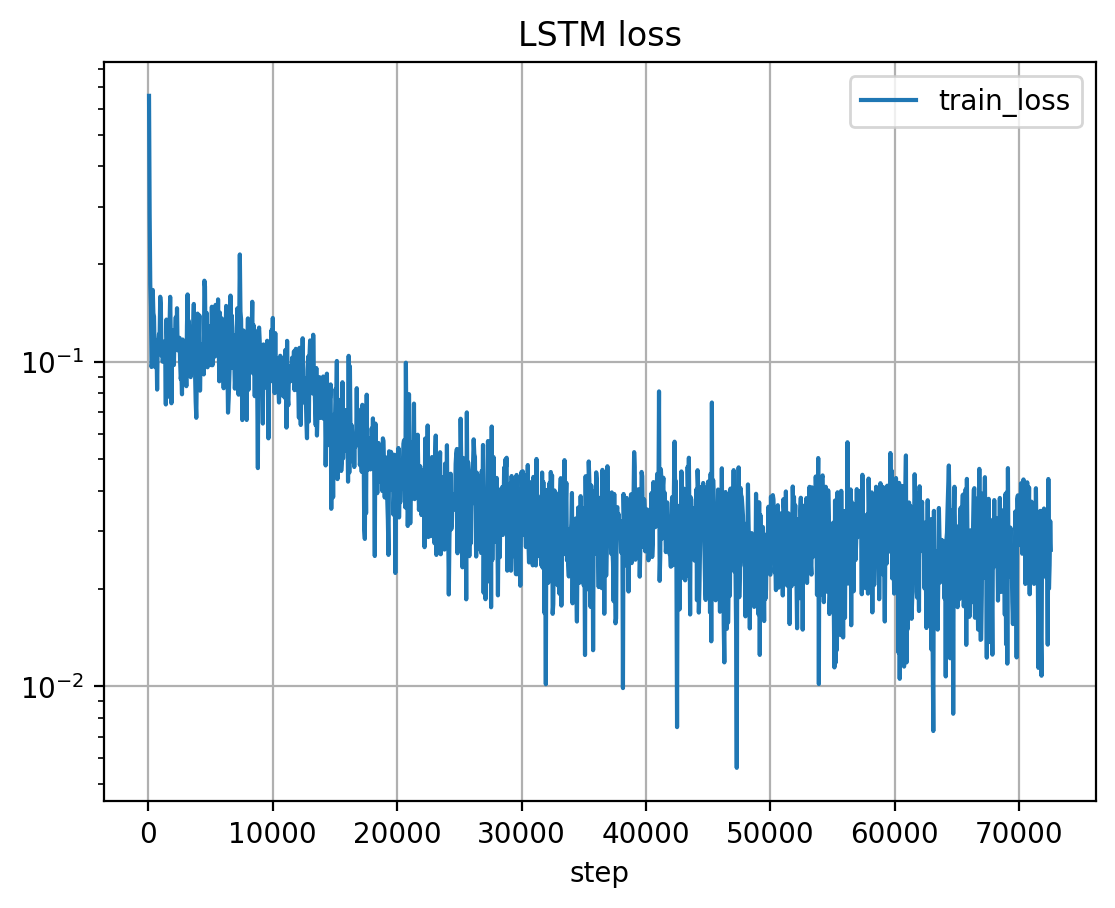

In [19]:
import pandas as pd

df_simple_metrics = pd.read_csv("logs/lstm_net/version_0/metrics.csv")
df_simple_metrics.plot.line(
    grid=True, title="LSTM loss", x="step", y="train_loss", logy=True
);

In [23]:
for sample in piano_roll_dataset:
    piano_roll_sample = sample
    break
piano_roll_sample

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

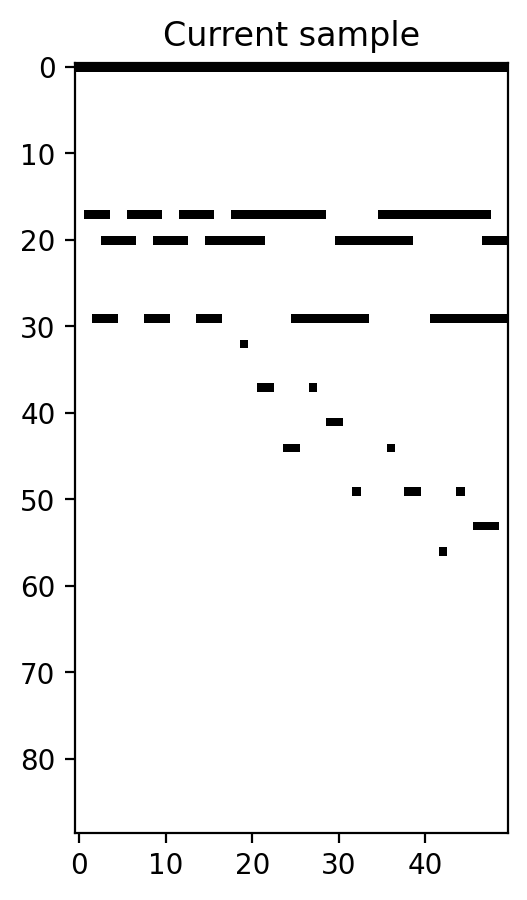

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(piano_roll_sample[0].T, cmap="binary");
plt.title("Current sample");

/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


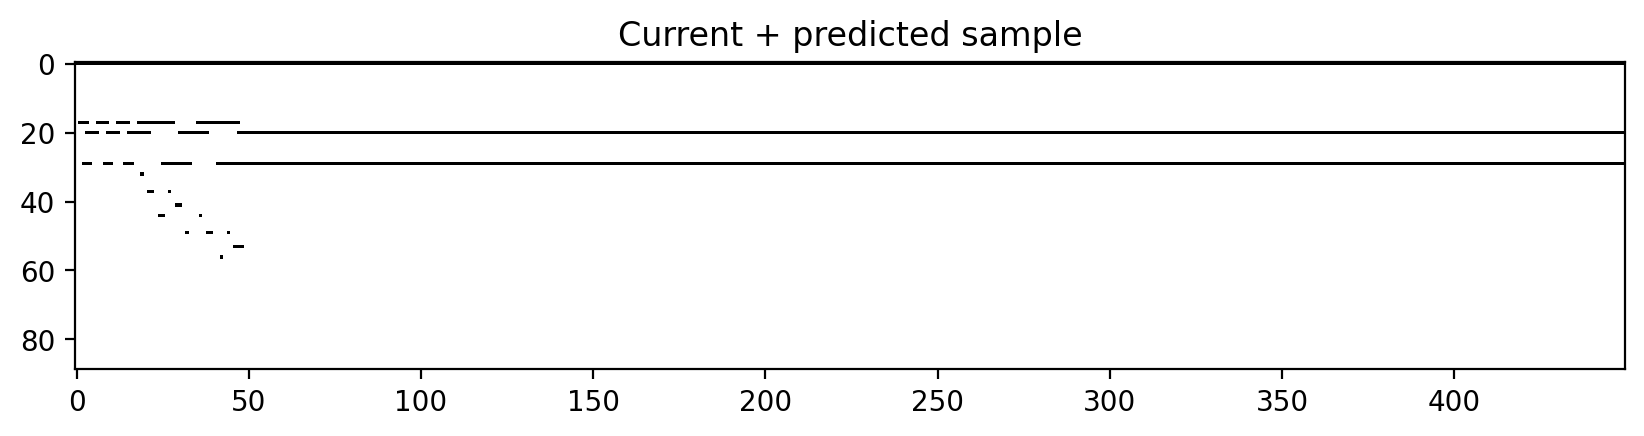

In [25]:
note_sequence = piano_roll_sample[0]

for i in range(400):
    next_frame = lstm_net.forward(note_sequence.unsqueeze(0))
    binary_frame = (torch.nn.Softmax()(next_frame) > 0.01).to(torch.float32)
    note_sequence = torch.concat([note_sequence, binary_frame])

predicted_sequence = note_sequence.detach().numpy()

plt.figure(figsize=(10, 5))
plt.imshow(predicted_sequence.T, cmap="binary");
plt.title("Current + predicted sample");

In [53]:
import lightning as L
from torch import nn, optim


class PenalizedLSTMNet(L.LightningModule):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        num_layers: int = 1,
        dropout: float = 0.2,
        learning_rate: float = 1e-4,
    ):
        super().__init__()
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.criterion = nn.BCEWithLogitsLoss()
    
    def forward(self, x):
        rnn_out, _ = self.lstm(x)
        # only use output from last step of our rnn sequence
        output = self.fc(rnn_out[:, -1, :])
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.squeeze(1)) + (1e-2 * self.zero_vector_penalty(y_hat))
        self.log("train_loss", loss, prog_bar=True)
        return loss

    @staticmethod
    def zero_vector_penalty(y):
        norm = torch.norm(y, p=2.0, dim=-1)
        # force to activate something
        return torch.mean(torch.exp(-norm))

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)


penalized_lstm_net = PenalizedLSTMNet(
    # without pedal
    input_size=88,
    output_size=88,
    hidden_size=128,
    num_layers=2,
    learning_rate=1e-3,
)

print(penalized_lstm_net)

PenalizedLSTMNet(
  (lstm): LSTM(88, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=88, bias=True)
  (criterion): BCEWithLogitsLoss()
)


In [54]:
from pytorch_lightning.loggers import CSVLogger
import torch 

# for tensor cores
torch.set_float32_matmul_precision('high')

simple_trainer = L.Trainer(
    max_epochs=5, logger=[CSVLogger(save_dir="logs", name="lstm_net", version=0)]
)
simple_trainer.fit(model=penalized_lstm_net, train_dataloaders=context_data_loader_wo_pedal)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/lstm_net/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/lstm_net/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | lstm      | LSTM              | 243 K  | train
1 | fc        | Linear            | 11.4 K | train
2 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
255 K     Trainable params
0   

Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [31:20<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [31:20<?, ?it/s]
Epoch 0: |          | 0/? [31:20<?, ?it/s]
Epoch 0: |          | 0/? [30:01<?, ?it/s]
Epoch 0: |          | 0/? [31:20<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [31:20<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [31:20<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [31:20<?, ?it/s]
Epoch 0: |          | 0/? [33:27<?, ?it/s]
Epoch 0: |          | 0/? [31:20<?, ?it/s]
Epoch 0: | 


Detected KeyboardInterrupt, attempting graceful shutdown ...


Epoch 0: |          | 0/? [43:54<?, ?it/s]
Epoch 0: |          | 0/? [41:47<?, ?it/s]
Epoch 0: |          | 0/? [40:28<?, ?it/s]
Epoch 0: |          | 0/? [38:52<?, ?it/s]
Epoch 0: |          | 0/? [37:28<?, ?it/s]
Epoch 0: |          | 0/? [36:59<?, ?it/s]
Epoch 0: |          | 0/? [36:31<?, ?it/s]


NameError: name 'exit' is not defined

/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


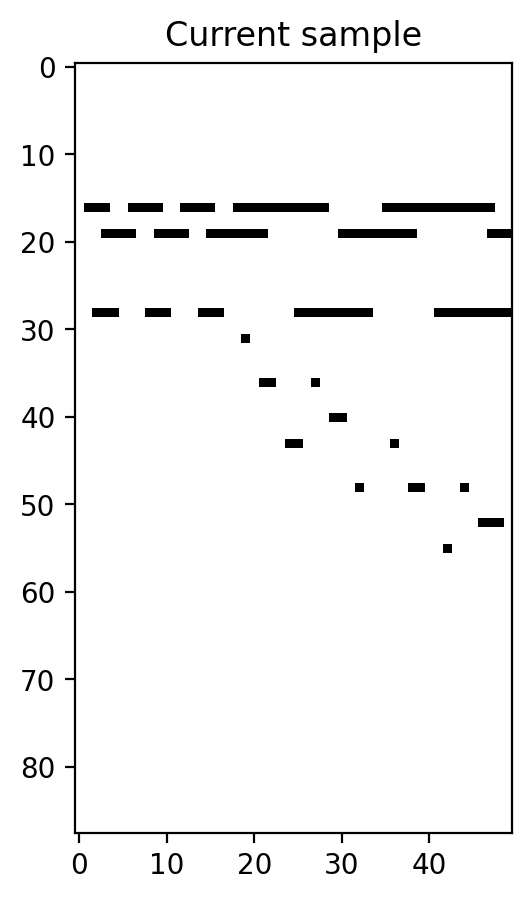

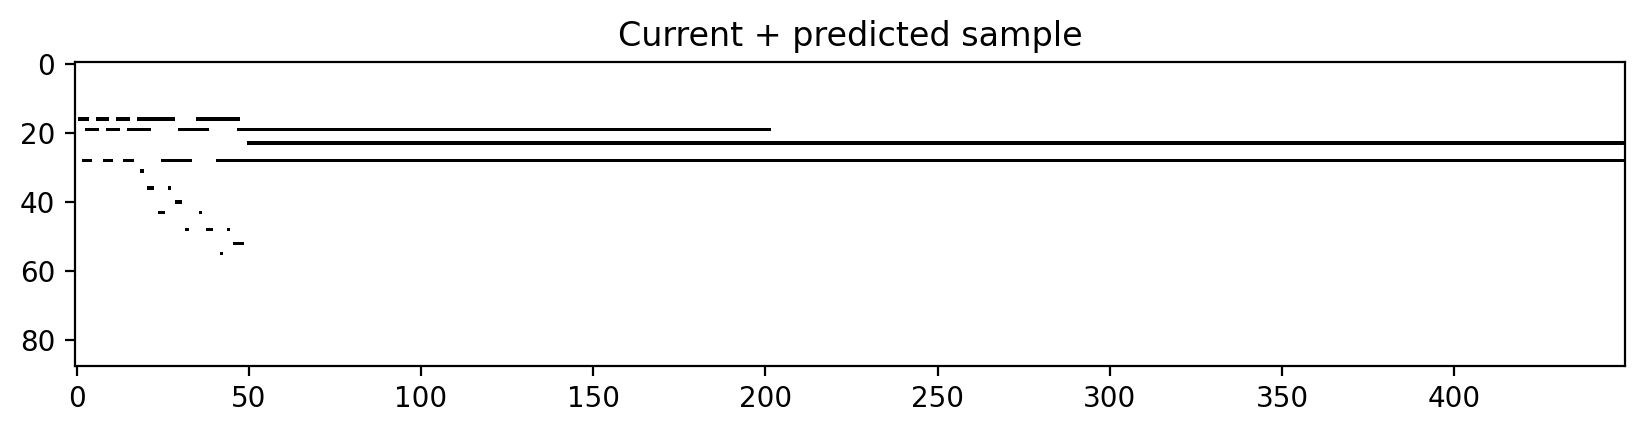

In [58]:
for sample in piano_roll_wo_pedal_dataset:
    piano_roll_sample = sample
    break

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(piano_roll_sample[0].T, cmap="binary");
plt.title("Current sample");
note_sequence = piano_roll_sample[0]

for i in range(400):
    next_frame = penalized_lstm_net.forward(note_sequence.unsqueeze(0))
    binary_frame = (torch.nn.Softmax()(next_frame) > 0.01).to(torch.float32)
    note_sequence = torch.concat([note_sequence, binary_frame])

predicted_sequence = note_sequence.detach().numpy()

plt.figure(figsize=(10, 5))
plt.imshow(predicted_sequence.T, cmap="binary");
plt.title("Current + predicted sample");

In [61]:
events_df = piano_roll.events(0.008)

In [69]:
possible_velocity_steps = np.linspace(1, 127, 32, dtype=np.int32)
possible_velocity_steps

array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  66,  70,  74,  78,  82,  86,  90,  94,  98, 102,
       106, 110, 114, 118, 122, 127], dtype=int32)

In [81]:
quantize(239, 0, 127, 4, 0, 127)

(1.75, 222.25)

In [187]:
from typing import NamedTuple

class QuantizedValue(NamedTuple):
    quantized_value: int
    scaled_value: float

def quantize(value, in_min, in_max, steps: int, out_min=0.0, out_max=1.0) -> QuantizedValue:
    normalized_value = (value - in_min) / (in_max - in_min)
    quantized_value = np.floor(normalized_value*steps) / steps
    scaled_value = (quantized_value * (out_max - out_min)) + out_min
    return QuantizedValue(int(quantized_value), scaled_value)

In [139]:
df = events_df.pivot_table(values="velocity", index="time", columns="note", aggfunc="max")
# *10e8 for scaling reasons for some reason...
df = df.set_index(pd.to_timedelta(df.index * 10e8))
# df.resample('8ms').max()
df

note,-1,26,27,28,29,30,31,32,33,34,...,95,96,97,98,99,100,101,102,103,104
time,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0 days 00:00:00.437500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0 days 00:00:00.959635416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0 days 00:00:01.342447916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0 days 00:00:01.466145833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:16:30.904947916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0 days 00:16:31.278645833,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0 days 00:16:31.299479166,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


991.3385416667126

In [171]:
len(np.arange(0, len(time_slots)))

124000

In [175]:
time_slots = np.arange(0.0, np.ceil(events_df['time'].max()), 0.008)
events_df['time_slot'] = pd.cut(events_df['time'], bins=time_slots, include_lowest=True, labels=np.arange(0, len(time_slots)-1))
events_df.head()

,note,velocity,time,next_time,time_slot
0,-1,127,0.000000,0.437500,0
1,37,25,0.437500,0.522135,54
2,49,30,0.959635,0.382812,119
3,40,47,1.342448,0.123698,167
4,37,0,1.466146,0.240885,183


In [189]:
NUM_TIME_SLOTS = 125
NUM_VELOCITIES = 32

midi_vector = list()
latest_time_slot = 0

for time_slot, time_group in events_df.groupby("time_slot"):
    note_on = np.zeros(shape=(89))
    note_off = np.zeros(shape=(89))
    velocity_vector = np.zeros(shape=(NUM_VELOCITIES))
    time_vector = np.zeros(shape=(NUM_TIME_SLOTS))

    velocity = None

    for _, event in time_group.iterrows():
        if event['note'] == -1:
            midi_note = 88
        else:
            midi_note = event['note'] - 21
        if event['velocity'] > 0:
            note_on[int(midi_note)] = 1
            velocity = event['velocity']
        else:
            note_off[int(midi_note)] = 1
    
    if velocity:
        velocity_pos = quantize(velocity, in_min=0, in_max=127, steps=NUM_VELOCITIES).quantized_value
        velocity_vector[velocity_pos] = 1
    
    time_pos = min(max(0, latest_time_slot - time_slot), NUM_TIME_SLOTS)
    time_vector[time_pos] = 1

    midi_vector.append(np.concatenate([
        note_on,
        note_off,
        time_vector,
        velocity_vector,
    ]))
    latest_time_slot = time_slot


/tmp/ipykernel_16469/1519743834.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for time_slot, time_group in events_df.groupby("time_slot"):


In [191]:
np.array(midi_vector).shape

(123999, 335)

In [181]:
time_group

,note,velocity,time,next_time,time_slot
0,-1,127,0.0,0.4375,0


In [159]:
time_ranges = np.linspace(0.0, 1.0, 33)
pd.cut(events_df['time'].diff().fillna(0.0), bins=time_ranges, include_lowest=True)

0        (-0.001, 0.0312]
1          (0.406, 0.438]
2            (0.5, 0.531]
3          (0.375, 0.406]
4         (0.0938, 0.125]
               ...       
37464    (-0.001, 0.0312]
37465      (0.344, 0.375]
37466    (-0.001, 0.0312]
37467    (-0.001, 0.0312]
37468    (-0.001, 0.0312]
Name: time, Length: 37469, dtype: category
Categories (32, interval[float64, right]): [(-0.001, 0.0312] < (0.0312, 0.0625] < (0.0625, 0.0938] < (0.0938, 0.125] ... (0.875, 0.906] < (0.906, 0.938] < (0.938, 0.969] < (0.969, 1.0]]

In [145]:
df.index.diff().fillna(pd.Timedelta(0))

TimedeltaIndex([          '0 days 00:00:00',    '0 days 00:00:00.437500',
                '0 days 00:00:00.522135416', '0 days 00:00:00.382812500',
                '0 days 00:00:00.123697917', '0 days 00:00:00.240885417',
                '0 days 00:00:00.018229166', '0 days 00:00:00.179687500',
                '0 days 00:00:00.195312500', '0 days 00:00:00.333333334',
                ...
                '0 days 00:00:00.040364583', '0 days 00:00:00.013020833',
                '0 days 00:00:00.001302084', '0 days 00:00:00.022135416',
                '0 days 00:00:00.010416667', '0 days 00:00:00.001302083',
                '0 days 00:00:00.373697917', '0 days 00:00:00.020833333',
                '0 days 00:00:00.019531250', '0 days 00:00:00.019531250'],
               dtype='timedelta64[ns]', name='time', length=36112, freq=None)

ValueError: No axis named 3 for object type DataFrame

In [118]:
Maestro3Dataset().midi_file_paths[0]

PosixPath('/home/dennis/git/ki-ueben-klavier-trainieren/book/chapters/data/maestro-v3.0.0/maestro-v3.0.0/2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--4.midi')

In [75]:
import numpy as np

NUM_VELOCITY_STEPS = 32
NUM_TIME_STEPS = 32
TIME_STEPS = np.linspace(0.008, 1.0, NUM_TIME_STEPS)

events_df['next_time'] = events_df['time'].diff().shift(-1).fillna(0.0)

while True:
    note_on = np.zeros(shape=(89))
    note_off = np.zeros(shape=(89))
    
    break



# only convert note/velocity to vectors, copying the time stamp
for _, event in events_df.iterrows():
    note_on = np.zeros(shape=(89))
    note_off = np.zeros(shape=(89))

    midi_velocity = np.zeros(shape=(VELOCITY_STEPS))

    if event['velocity'] > 0:
        # pedal
        if event['note'] == -1:
            midi_note = 88
        else:
            midi_note = event['note'] - 21
    else:
        quantized_velocity = int(quantize(event['velocity'], 0, 127, VELOCITY_STEPS)[1])
        midi_velocity[quantized_velocity] = 1



SyntaxError: invalid syntax (1202223083.py, line 8)

In [95]:
events_df['next_time'] = events_df['time'].diff().shift(-1).fillna(0.0)
events_df

,note,velocity,time,next_time
0,-1,127,0.000000,0.437500
1,37,25,0.437500,0.522135
2,49,30,0.959635,0.382812
3,40,47,1.342448,0.123698
4,37,0,1.466146,0.240885
...,...,...,...,...
37464,67,0,990.904948,0.373698
37465,-1,110,991.278646,0.020833
37466,-1,78,991.299479,0.019531
37467,-1,49,991.319010,0.019531


In [92]:
events_df

,note,velocity,time,next_time
0,-1,127,0.000000,0.437500
1,37,25,0.437500,0.959635
2,49,30,0.959635,1.342448
3,40,47,1.342448,1.466146
4,37,0,1.466146,1.707031
...,...,...,...,...
37464,67,0,990.904948,991.278646
37465,-1,110,991.278646,991.299479
37466,-1,78,991.299479,991.319010
37467,-1,49,991.319010,991.338542


In [63]:
events_df

,note,velocity,time
0,-1,127,0.000000
1,37,25,0.437500
2,49,30,0.959635
3,40,47,1.342448
4,37,0,1.466146
...,...,...,...
37464,67,0,990.904948
37465,-1,110,991.278646
37466,-1,78,991.299479
37467,-1,49,991.319010


In [60]:
midi_file = Maestro3Dataset().midi_file_paths[0]
piano_roll = PianoRoll(midi_file)

In [14]:
piano_roll.drop(labels=[-1], axis=1)

note,21,22,23,24,25,26,27,28,29,30,...,99,100,101,102,103,104,105,106,107,108
time,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
0 days 00:00:00.437500,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
0 days 00:00:00.959635416,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
0 days 00:00:01.342447916,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
0 days 00:00:01.466145833,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:16:30.904947916,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
0 days 00:16:31.278645833,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
0 days 00:16:31.299479166,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [8]:
piano_roll_sample[0].shape

torch.Size([50, 89])

In [ ]:
piano_roll = PianoRoll(dataset_record["file_path"])
piano_roll

PianoRoll(/Users/scheiba/github/ki-ueben-klavier-trainieren/book/chapters/data/maestro-v3.0.0/maestro-v3.0.0/2013/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_2013_wav--1.midi)

In [ ]:
df_events = piano_roll.events()
df_events

,note,velocity,time
0,-1,0,0.000000
1,51,49,0.980469
2,63,57,0.997396
3,51,0,1.087240
4,50,64,1.093750
...,...,...,...
7301,-1,69,389.126302
7302,-1,64,389.145833
7303,-1,55,389.164062
7304,-1,37,389.184896


In [ ]:
from typing import Callable

import pandas as pd


class MidiVectorTransform:
    """Transforms multiple MIDI events stored within a DataFrame,
    happening at the same time into a vector.
    The DataFrame needs to have the columns

    * velocity
    * note
    * time_delta (delta from previous event) - it is not necessary to quantize this
    """

    def __init__(self, velocity_steps: int = 32, time_steps: int = 125, dtype=np.uint8):
        self.dtype = dtype

        self.velocity_steps = velocity_steps
        self.velocity_mask = np.eye(self.velocity_steps, dtype=self.dtype)

        self.time_steps = time_steps
        self.time_mask = np.eye(self.time_steps, dtype=self.dtype)

        self.num_midi = 128
        self.midi_mask = np.eye(self.num_midi, dtype=self.dtype)

    @property
    def transform_size(self) -> int:
        return (2 * self.num_midi) + self.velocity_steps + self.time_steps

    def _events(self, df: pd.DataFrame, selector: Callable[[int], bool]) -> np.ndarray:
        events = np.zeros(self.num_midi, dtype=self.dtype)
        for _, event in df[df["velocity"].apply(selector)].iterrows():
            events = events + self.midi_mask[int(event.note)]
        return events

    def _events_on(self, df: pd.DataFrame) -> np.ndarray:
        return self._events(df, selector=lambda x: x > 0)

    def _events_off(self, df: pd.DataFrame) -> np.ndarray:
        return self._events(df, selector=lambda x: x == 0)

    def _velocity(self, df: pd.DataFrame) -> np.ndarray:
        # todo: should this ignore 0 velocity at all?
        velocity = np.zeros(self.velocity_steps, dtype=self.dtype)

        mean_velocity = df[df["velocity"] > 0].velocity.mean()
        if not pd.isna(mean_velocity):
            quantized_velocity = int(
                np.floor(mean_velocity / 127 * self.velocity_steps)
            )
            velocity = self.velocity_mask[quantized_velocity]

        return velocity

    def _time(self, df: pd.DataFrame) -> np.ndarray:
        time = np.zeros(self.time_steps, dtype=self.dtype)
        if len(df) > 0:
            # clip between 0 and 1
            time_diff = np.clip(df.iloc[0].time_delta, 0.0, 1.0)
            time = self.time_mask[
                int(
                    np.clip(
                        np.floor(time_diff * self.time_steps), 0, self.time_steps - 1
                    )
                )
            ]
        return time

    def un_transform(self, sample):
        raise NotImplementedError()

    def __call__(self, df: pd.DataFrame) -> np.ndarray:
        # filter out empty messages and pedal messages
        df = df[df["note"] != -1]
        return np.concatenate(
            [
                self._events_on(df),
                self._events_off(df),
                self._velocity(df),
                self._time(df),
            ],
            dtype=self.dtype,
        )


transformer = MidiVectorTransform()

In [ ]:
df

,note,velocity,time,time_delta,quantized_time
0,-1,0,0.000000,0.980469,0.000
1,51,49,0.980469,0.016927,0.976
2,63,57,0.997396,0.089844,0.992
3,51,0,1.087240,0.006510,1.080
4,50,64,1.093750,0.071615,1.088
...,...,...,...,...,...
7301,-1,69,389.126302,0.019531,389.120
7302,-1,64,389.145833,0.018229,389.144
7303,-1,55,389.164062,0.020833,389.160
7304,-1,37,389.184896,0.019531,389.184


In [ ]:
def prepare_df(df: pd.DataFrame, num_time_steps: int = 125) -> pd.DataFrame:
    df["time_delta"] = df["time"].diff(-1).abs().fillna(1.0)
    df["quantized_time"] = np.floor(df["time"] * num_time_steps) / num_time_steps

    # remove pedal
    df = df[df["note"] > 0]

    return df


def df_quantized_iterator(df: pd.DataFrame):
    for group_df in df.groupby("quantized_time"):
        yield group_df

In [ ]:
from typing import Dict

from tqdm import tqdm

vectors: Dict[str, np.array] = {}

for midi_path in tqdm(dataset):
    vector = []

    piano_roll = PianoRoll(dataset_record["file_path"])
    df = piano_roll.events()

    for _, x in df_quantized_iterator(prepare_df(df)):
        vector.append(transformer(x))

    vectors[midi_path["file_path"].name] = np.array(vector)
    break

  0%|          | 0/1276 [00:07<?, ?it/s]


In [ ]:
vector = vectors["ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--1.midi"]

In [ ]:
vector.shape

(3667, 413)

In [ ]:
piano_roll

PianoRoll(/Users/scheiba/github/ki-ueben-klavier-trainieren/book/chapters/data/maestro-v3.0.0/maestro-v3.0.0/2013/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_2013_wav--1.midi)

In [ ]:
vector[-1:, :].shape

(1, 413)

In [ ]:
class LSTM(L.LightningModule):
    def __init__(
        self,
        hidden_size: int = 512,
        midi_size: int = 128,
        velocity_steps: int = 32,
        time_steps: int = 125,
    ):
        super().__init__()

        self.velocity_steps = velocity_steps
        self.time_steps = time_steps
        self.midi_size = midi_size

        self.input_dim = (2 * self.midi_size) + self.velocity_steps + self.time_steps
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=hidden_size,
            num_layers=3,
            dropout=0.3,
            batch_first=True,
        )
        self.linear = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.input_dim,
        )

    def forward(self, batch):
        # !!! batch needs to be!!!
        # * midi_in
        # * midi_out
        # * velocity
        # * time

        lstm_out, (hn, cn) = self.lstm(batch)
        # only select the last output of the lstm
        # we need to unsqueeze because selecting a single element
        # will delete the dimension as well
        lstm_out = lstm_out[:, -1:, :]
        return self.linear(lstm_out)

    def note_on(self, t: torch.Tensor) -> torch.Tensor:
        return t[:, :, 0 : self.midi_size]

    def note_off(self, t: torch.Tensor) -> torch.Tensor:
        return t[:, :, self.midi_size : self.midi_size * 2]

    def velocity(self, t: torch.Tensor) -> torch.Tensor:
        return t[:, :, self.midi_size * 2 : (self.midi_size * 2) + self.velocity_steps]

    def time(self, t: torch.Tensor) -> torch.Tensor:
        # @todo this is wrong!
        return t[:, :, -self.time_steps :]

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)

        # losses = torch.concatenate([
        #     nn.functional.mse_loss(self.note_on(y), self.note_on(out)),
        #     # nn.CrossEntropyLoss()(self.velocity(x), self.velocity(out))
        # ])

        note_on_loss = nn.functional.mse_loss(self.note_on(out), self.note_on(y))
        # have different losses for each section
        time_loss = nn.functional.cross_entropy(self.time(out), self.time(y))

        self.log("train_note_on_loss", note_on_loss)
        self.log("train_time_loss", time_loss)

        return note_on_loss + time_loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


lstm = LSTM()

print(lstm)

LSTM(
  (lstm): LSTM(413, 512, num_layers=3, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=512, out_features=413, bias=True)
)


In [ ]:
lstm.note_on(out).shape

torch.Size([1, 1, 128])

In [ ]:
from typing import Iterator

import torch.utils.data


class TimeSeriesDataset(torch.utils.data.IterableDataset):
    def __init__(self, vectors: np.ndarray, num_pre: int, num_post: int = 1):
        self.vectors = vectors
        self.num_pre = num_pre
        self.num_post = num_post

    def __iter__(self) -> Iterator:
        for offset in np.arange(
            0, self.vectors.shape[0] + self.num_post + self.num_pre
        ):
            yield self.vectors[offset : offset + self.num_pre], self.vectors[
                offset + self.num_pre : offset + self.num_pre + self.num_post
            ]


dataset = TimeSeriesDataset(
    vectors=torch.Tensor(vector.astype(np.float32)), num_pre=100, num_post=1
)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=28)

In [ ]:
trainer = L.Trainer(limit_train_batches=100, max_epochs=2, log_every_n_steps=1)
trainer.fit(model=lstm, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 6.1 M 
1 | linear | Linear | 211 K 
----------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.251    Total estimated model params size (MB)
/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s, v_num=42]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s, v_num=42]


In [ ]:
trainer.logged_metrics

{'train_note_on_loss': tensor(0.0041), 'train_time_loss': tensor(-0.)}

In [ ]:
out = lstm.forward(torch.Tensor(vector[0:100].astype(np.float32)).unsqueeze(0))

In [ ]:
out[0, 0, :]

tensor([ 3.8971e-03, -1.2172e-03, -2.4754e-03, -3.7213e-03, -2.7787e-03,
        -2.5138e-04,  1.7865e-03, -2.6892e-04,  1.8892e-03, -1.5990e-03,
         3.2224e-04,  9.8781e-04, -1.4894e-03, -2.0432e-03,  2.9413e-03,
        -1.7089e-03,  9.7648e-03, -1.2814e-03, -1.8693e-03, -3.8153e-03,
        -5.2325e-03,  2.3664e-03,  8.2530e-04, -1.2044e-03, -2.1420e-03,
        -6.7895e-04, -1.5671e-03,  2.7583e-03,  3.3898e-03,  5.4249e-03,
        -2.0362e-03,  3.2021e-03, -9.8711e-04,  2.5240e-03, -2.1509e-04,
        -1.2053e-04,  1.2406e-03,  3.5846e-04, -2.5151e-04, -5.0175e-03,
        -2.1750e-03, -5.8116e-03,  8.4303e-03,  1.2473e-02,  3.3065e-03,
         4.9784e-04,  3.2720e-03, -1.1198e-03,  5.0466e-03,  9.6616e-03,
         6.7661e-03,  3.2104e-02,  1.1356e-02,  1.5208e-02,  2.1413e-02,
        -1.3461e-03,  1.1828e-02, -4.4166e-03,  3.0715e-02,  1.0709e-02,
         2.2356e-02,  1.2477e-02,  1.4657e-02,  4.9933e-02,  9.8639e-03,
         5.0932e-03,  3.4576e-02,  2.8624e-02,  3.1

In [ ]:
torch.argmax(lstm.velocity(out)[0, 0])

tensor(28)

In [ ]:
lstm.note_on(out)[0, 0] > 0.04

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False])

In [ ]:
lstm.velocity_steps

32

In [ ]:
lstm.velocity(out[0, 0]).max()

tensor(0.0518, grad_fn=<MaxBackward1>)

In [ ]:
np.argmax(lstm.time(out[0, 0]).detach().numpy())

269

In [ ]:
lstm.time_steps

125

In [ ]:
out.shape

torch.Size([1, 1, 413])

In [ ]:
(out > 0.2).sum()

tensor(1)

In [ ]:
vectors.shape

(6677, 413)

In [ ]:
dataset = torch.utils.data.TensorDataset(
    torch.Tensor(vectors[:-1]), torch.Tensor(vectors[1:])
)

In [ ]:
dataset[10][0].shape

torch.Size([413])

In [ ]:
output = lstm.forward(
    torch.Tensor(vectors[10:20]).unsqueeze(dim=0),
)

In [ ]:
vectors[10:20].shape

(10, 413)

In [ ]:
output.shape

torch.Size([1, 333])

In [ ]:
class LSTM(L.LightningModule):
    def __init__(
        self, mp 
        n_features=88,
        hidden_size=12,
        seq_len=12,
        batch_size=12,
        num_layers=12,
        dropout=0.2,
        output_size=88,
    ):
        super().__init__()

        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.output_size = output_size
    
        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=self.dropout,
            batch_first=True,
        )
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    